# Preliminary data analysis

## Housekeepin’

In [1]:
# # lan model
# import requests
# ftm_url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
# r = requests.get(ftm_url, allow_redirects=True)
# open("../../data/lid.176.bin", "wb").write(r.content)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# docs
docs_augmented = pd.read_pickle("../../data/docs-augmented.pkl")
#docs_augmented = docs_augmented.loc[:500,:]
docs_augmented.head(3)

,Participant,Sector,Country,Year,Language,Link,FileType,FileName,FileTypeMagic,ConversionStatus,ConvertedFileName,OCRStatus,OutputText,OutputFileName
0,AGNI MOTORS,Electronic & Electrical Equ...,India,2019,english,https://ungc-production.s3.us-west-2.amazonaws...,pdf,0000-2019-agni-motors.pdf,application/pdf,NaN,0000-2019-agni-motors.pdf,0,® AGNI MOTORS ay AN ISO 9001 : 2008 COMPANY Ag...,../../data/text-reports/0000-2019-agni-motors.txt
1,AMBEV S/A,Beverages,Brazil,2019,english,https://ungc-production.s3.us-west-2.amazonaws...,pdf,0001-2019-ambev-s-a.pdf,application/pdf,NaN,0001-2019-ambev-s-a.pdf,0,SUSTAINABILITY REPORT 2018 “= ( a .) ‘J ambev ...,../../data/text-reports/0001-2019-ambev-s-a.txt
2,Access Spectrum Company Limited,Technology Hardware & Equip...,Myanmar,2019,english,https://ungc-production.s3.us-west-2.amazonaws...,pdf,0002-2019-access-spectrum-company-limited.pdf,application/pdf,NaN,0002-2019-access-spectrum-company-limited.pdf,0,H.E. ANTONIO GUTERRES Secretary General Unit...,../../data/text-reports/0002-2019-access-spect...


In [3]:
display(docs_augmented.shape[0])
display(docs_augmented.OutputText.isnull().sum())
docs_augmented = docs_augmented[docs_augmented.OutputText.notnull()]

500

1

In [4]:
docs_augmented.Year.value_counts()

2020    350
2019    149
Name: Year, dtype: int64

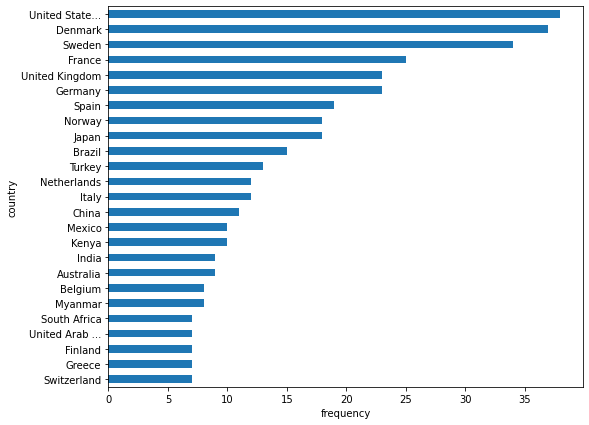

In [5]:
f, ax = plt.subplots(1,1,figsize=(8.5,7))
docs_augmented.groupby("Country").Participant.count().\
    sort_values().tail(25).plot(kind="barh", ax=ax);
ax.set_ylabel("country");
ax.set_xlabel("frequency");

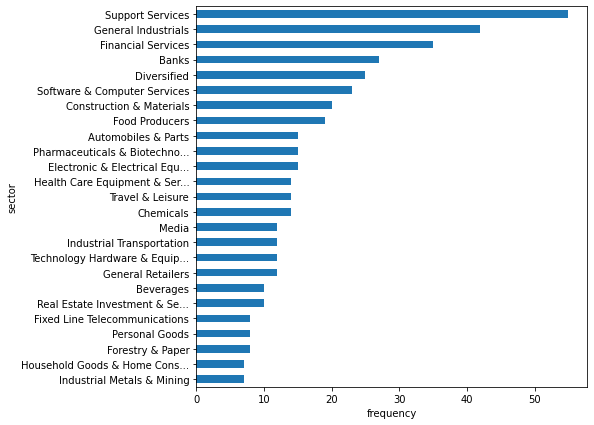

In [6]:
f, ax = plt.subplots(1,1,figsize=(7,7))
docs_augmented.groupby("Sector").Participant.count().\
    sort_values().tail(25).plot(kind="barh", ax=ax);
ax.set_ylabel("sector");
ax.set_xlabel("frequency"); 

In [7]:
# avg documents per participant, possible concat?
docs_augmented.Participant.value_counts().mean()

1.03099173553719

## Texts

In [8]:
# simple pre-proc
def purge_chars(string):
    import re
    string = string.lower()
    string = re.sub("<.*?>|</.*?>","", string)
    string = re.sub("(s?)(f|ht)tp(s?)://\\S+\\b","",string)
    string = re.sub("[^a-z@ '.,?!\\-:]"," ",string)
    string = re.sub(r"\b(\w+\s*)\1{1,}", " ", string) #dupli '\\1'
    return re.sub("\\s+"," ", string)

docs_augmented["OutputChars"] = docs_augmented.apply(lambda x: purge_chars(x.OutputText), axis=1)    

In [9]:
%%capture
# chars, no of tokens, no of sentences, languages

def get_characteristics(df):
    import re
    import pandas as pd
    import fasttext as fs
    string = df.OutputChars
    df["n_chars"] = len(string)
    df["n_words"] = len(re.split("\\W+",string))
    df["n_sents"] = len(re.split("[.!?]", string))
    ftm = fs.load_model("../../data/lid.176.bin")
    lest = ftm.predict(string, k=1)
    df["lang_est"] = lest[0][0].split("_")[-1]
    df["lang_est_conf"] = lest[1][0]
    return df

docs_augmented = docs_augmented.apply(get_characteristics, axis=1)    

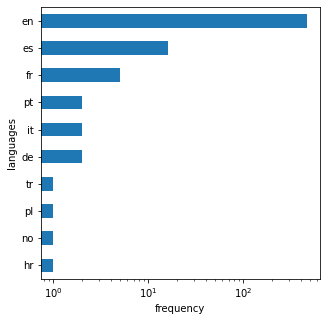

In [10]:
f, ax = plt.subplots(1,1,figsize=(5,5))
docs_augmented.groupby("lang_est").Participant.count().\
    sort_values().tail(25).plot(kind="barh", ax=ax, logx=True);
ax.set_ylabel("languages");
ax.set_xlabel("frequency"); 

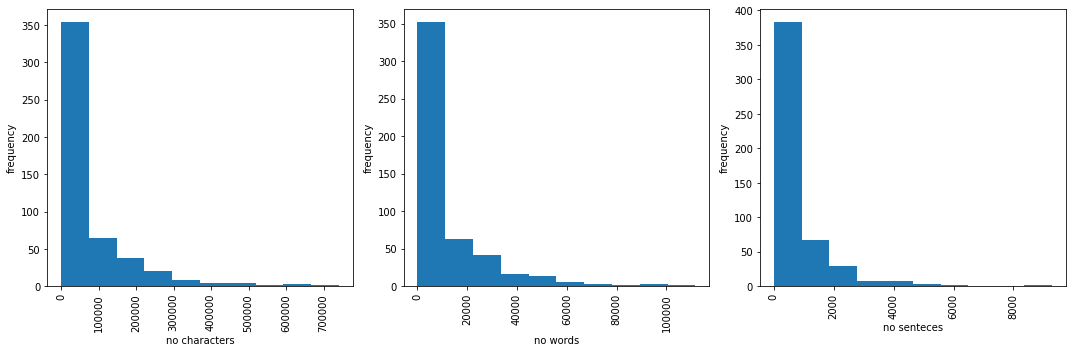

In [11]:
# plot it
f, axs = plt.subplots(1,3,figsize=(15,5))
counts = {"n_chars":"no characters", "n_words":"no words", "n_sents":"no senteces"}
for c, ax in zip(counts.keys(), axs.flatten()):
    docs_augmented[c].plot(kind="hist", ax=ax, rot=90);
    ax.set_ylabel("frequency");
    ax.set_xlabel(counts[c]);
f.tight_layout();

In [12]:
docs_augmented = docs_augmented[(docs_augmented.lang_est=="en") & (docs_augmented.lang_est_conf>0.6) & (docs_augmented.n_chars>=1000)]

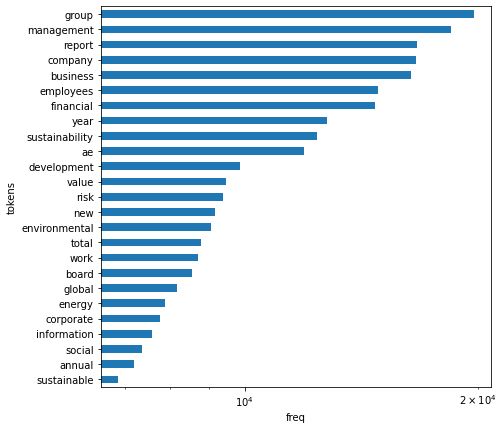

In [13]:
#  the most frequent tokens
from sklearn.feature_extraction.text import CountVectorizer
tokvec = CountVectorizer(max_features=25, stop_words="english",
    min_df=5)
token_counts = tokvec.fit_transform(docs_augmented.OutputChars)
f, ax = plt.subplots(1,1,figsize=(7,7))
pd.DataFrame(token_counts.toarray(), columns=tokvec.get_feature_names()).\
    sum().sort_values().plot(kind="barh", ax=ax, logx=True);
ax.set_ylabel("tokens");
ax.set_xlabel("freq"); 

In [14]:
import gc
del tokvec, token_counts
gc.collect()

1743

In [15]:
# 1,2,3-grams
gramvec = CountVectorizer(ngram_range=(1,3), stop_words="english",
   min_df=10, max_features=5000)
gram_counts = gramvec.fit_transform(docs_augmented.OutputChars)
gram_counts = pd.DataFrame(gram_counts.todense(),
    columns=gramvec.get_feature_names())
gram_counts = gram_counts.sum().reset_index()
gram_counts.columns = ["ngram", "frequency"]
gram_counts["n"] = gram_counts.ngram.apply(lambda x: len(x.split(" ")))

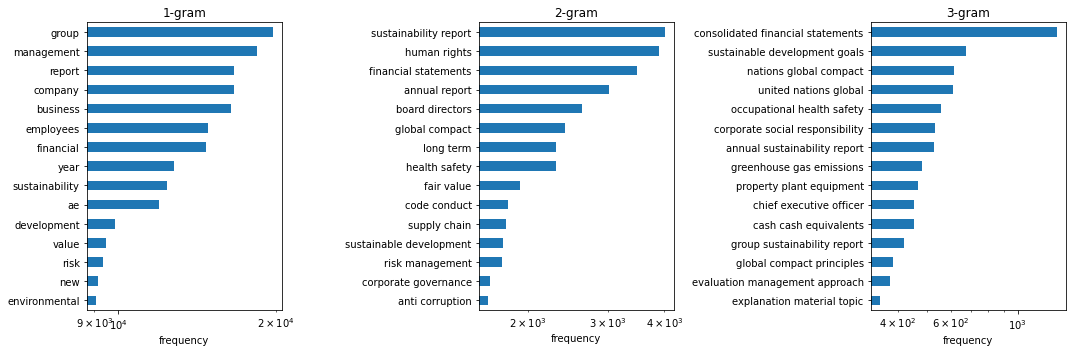

In [16]:
f, axs = plt.subplots(1,3,figsize=(15,5))
for ax, n in zip(axs, gram_counts.n.unique()):
    gram_counts[gram_counts.n==n].sort_values("frequency").tail(15).\
        plot(y="frequency",x="ngram", kind="barh", ax=ax, legend="false",
        logx=True)
    ax.set_title(str(n)+"-gram");
    ax.set_ylabel("");
    ax.set_xlabel("frequency");
    ax.get_legend().remove();
f.tight_layout()  

In [17]:
del gramvec, gram_counts
gc.collect()

28750

In [18]:
# upos
def get_upos(text,i):
    import spacy
    nlp =  spacy.load("en_core_web_lg")
    nlp.max_length = 1500000
    parsed = nlp(text)
    ls = [(i, t.text, t.lemma_, t.pos_, t.tag_, t.dep_,
    t.shape_, t.is_alpha, t.is_stop) for t in parsed]
    return pd.DataFrame(ls,
        columns=["doc_id","text", "lemma", "pos", "tag",
            "dep", "shape", "is_alpha", "is_stopword"])

from joblib import Parallel, delayed

upos_ls = Parallel(n_jobs=4)(delayed(get_upos)(docs_augmented.OutputChars.loc[i],i)\
    for i in docs_augmented.index)
docs_upos = pd.concat(upos_ls)

# common ones
docs_upos.pos.value_counts().sort_values().tail(5)

VERB      574135
PROPN     589950
ADP       688103
PUNCT     754096
NOUN     1763616
Name: pos, dtype: int64

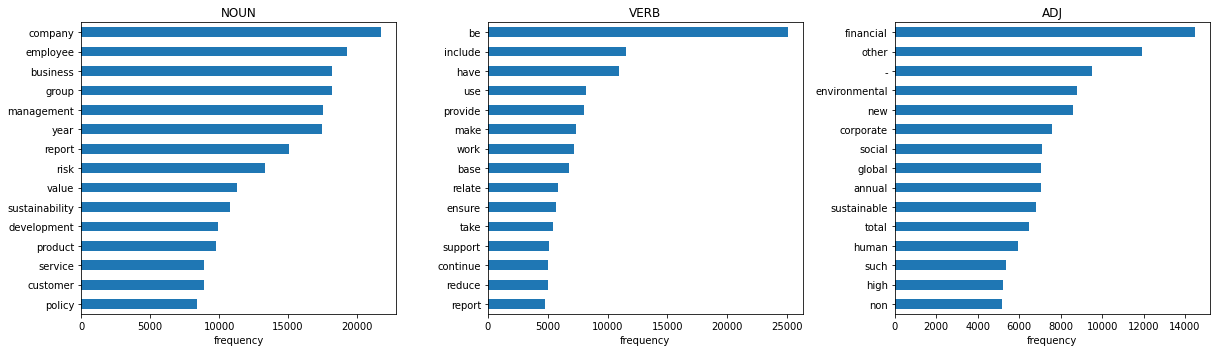

In [19]:
# barh noun, verb, adj
upos_subset = ["NOUN", "VERB","ADJ"]
f, axs = plt.subplots(1,3,figsize=(17,5))
for ax, up in zip(axs, upos_subset):
    docs_upos[docs_upos.pos==up].lemma.value_counts().sort_values().tail(15).\
        plot(kind="barh", ax=ax, legend="false")
    ax.set_title(up)
    ax.set_xlabel("frequency");
    ax.get_legend().remove()
f.tight_layout()

In [22]:
uf = (docs_upos.pos.isin(["NOUN", "VERB", "ADJ"])) & (np.logical_not(docs_upos.is_stopword)) & (docs_upos.lemma.str.len()>2) &\
    (docs_upos.text.str.len()<51)

docs_reconstructed = docs_upos[uf].groupby("doc_id").\
    apply(lambda x: " ".join(x["lemma"]))
del docs_upos
gc.collect()

19992

In [24]:
# rake - example
import spacy
from rake_spacy import Rake

def filter_tokens(token):
    return (token.is_stop or token.is_space or token.is_punct) and not (token.like_num)\
        and (token.pos_ not in ["ADJ", "VERB", "NOUN"]) and (len(token.text)<2)

rake = Rake(nlp=spacy.load("en_core_web_lg"), min_length=2, max_length=5,
    stop_token_class=filter_tokens)

rake.apply(docs_augmented.OutputChars[0])[:10]

[(9.0, day operations of our company),
 (9.0, environment and anti-corruption),
 (7.0, agni motors ay an iso),
 (7.0, am un gc g date),
 (7.0, disclosure of any relevant policies),
 (6.0, agni motors will make),
 (6.0, anti-corruption),
 (6.0, measurement of outcomes i.e.),
 (5.0, company agni),
 (5.0, culture and day)]

In [25]:
# coocurence
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

coovec = TfidfVectorizer(stop_words="english",
    ngram_range=(1,1), max_features=1000)
coo_w = coovec.fit_transform(docs_reconstructed)
tokens = coovec.get_feature_names()
#coo_f[coo_f>0]=1
coo_w = coo_w.T.dot(coo_w)
coo_w = np.triu(coo_w.todense(), k=1)

from itertools import combinations
edges = list(combinations(range(coo_w.shape[0]),2))
ind0, ind1 = [e[0] for e in edges], [e[1] for e in edges]
freq = coo_w[ind0,ind1]

coo_counts = pd.DataFrame(columns=["from", "to", "weight"])
coo_counts["from"], coo_counts["to"]  = [tokens[i]for i in ind0], [tokens[i]for i in ind1]
coo_counts["weight"] = freq
coo_counts.sort_values("weight").tail(15)

,from,to,weight
156283,company,work,4.715691
261812,employee,environmental,4.719223
100933,business,principle,4.798344
156086,company,report,4.806168
261913,employee,group,4.814553
101211,business,work,4.886811
262172,employee,policy,5.291941
262049,employee,management,5.314002
262301,employee,right,5.423776
262276,employee,report,5.473118


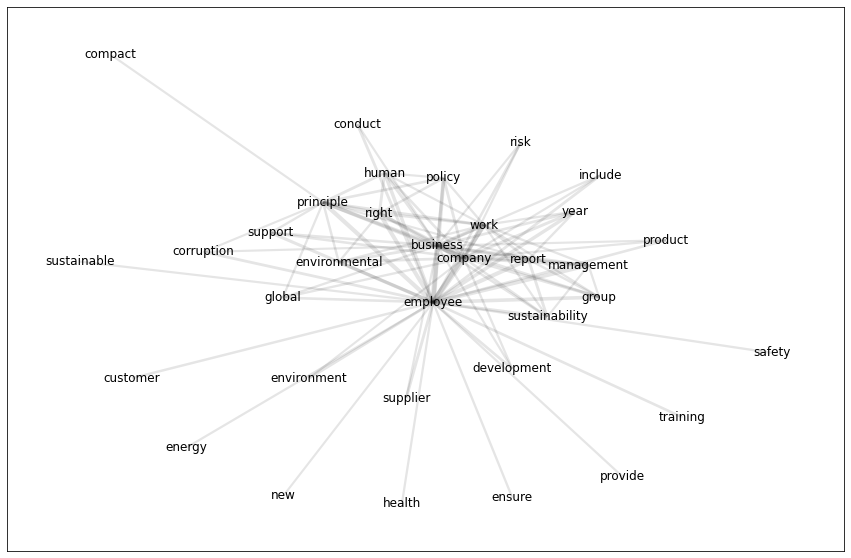

In [38]:
# networkx
import networkx as nx
net = nx.convert_matrix.from_pandas_edgelist(coo_counts.sort_values("weight").tail(100),
    source="from", target="to", edge_attr="weight")
f,ax = plt.subplots(1,1,figsize=(15, 10))
pos = nx.spring_layout(net, seed=1, iterations=100)
nx.draw_networkx_labels(net, pos, font_size=12,
    font_family="sans-serif", alpha=1, ax=ax);
nx.draw_networkx_edges(net, width=[net[u][v]['weight']*.75 for u,v in net.edges()],
    pos=pos, alpha=.1);

In [36]:
# lda topics
from sklearn.decomposition import LatentDirichletAllocation

tfidfvec = TfidfVectorizer(min_df=25, max_features=5000)
tfidf_counts = tfidfvec.fit_transform(docs_reconstructed)

lda = LatentDirichletAllocation(n_components=15, max_iter=10,
    learning_method='online', learning_offset=50., random_state=0)
lda.fit(tfidf_counts)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=15, random_state=0)

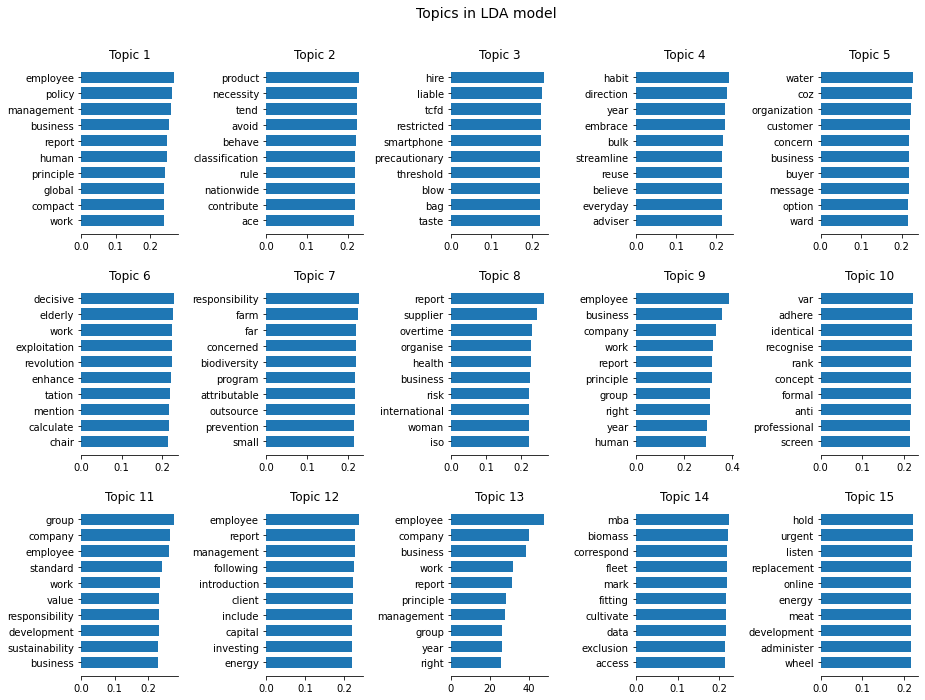

In [37]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 12})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=14)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, tfidfvec.get_feature_names(), 10, "Topics in LDA model")